In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


# MODELE SIMPLE

In [3]:
nb_actifs = 20
nb_dates = 256 * 5

idx = pd.Index(np.arange(nb_actifs))

mu = pd.Series(0.05,index=idx)
vols = pd.Series(0.2,index=idx)
correl = 0.7

covar = np.diag(vols) @ pd.DataFrame(correl * np.ones((nb_actifs,nb_actifs)) + (1-correl) * np.eye(nb_actifs),index=idx,columns=idx) @ np.diag(vols)
A = np.linalg.cholesky(covar)

rdts_observes = mu/256 + pd.DataFrame(np.random.randn(nb_dates,nb_actifs)) @ A.T / 16

In [4]:
mu_estime = rdts_observes.mean() * 256
covar_estimee = rdts_observes.cov() * 256
alloc_optimale_in_sample = pd.DataFrame(np.linalg.inv(covar_estimee),index=idx,columns=idx) @ mu_estime

Sharpe = 1.7781537305071413


<AxesSubplot:>

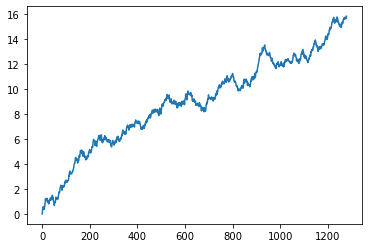

In [5]:
pnl_in_sample = rdts_observes @ alloc_optimale_in_sample
print('Sharpe = ' + str(pnl_in_sample.mean()/pnl_in_sample.std()*16))
pnl_in_sample.cumsum().plot()

In [6]:
nb_nouvelles_dates = 256

Sharpe = -1.035410656363789


<AxesSubplot:>

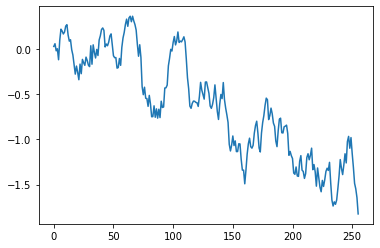

In [7]:
nouveaux_rdts = mu/256 + pd.DataFrame(np.random.randn(nb_nouvelles_dates,nb_actifs)) @ A.T / 16
pnl_out_sample = nouveaux_rdts @ alloc_optimale_in_sample
print('Sharpe = ' + str(pnl_out_sample.mean()/pnl_out_sample.std()*16))
pnl_out_sample.cumsum().plot()

In [8]:
nb_simu = 1000
pnls_out_sample = pd.DataFrame(mu @ alloc_optimale_in_sample /256 + (np.random.randn(nb_simu,nb_nouvelles_dates,nb_actifs) @ A.T @ alloc_optimale_in_sample.values/ 16)).T

In [9]:
sharpes_out_sample = pnls_out_sample.mean() / pnls_out_sample.std() * 16
sharpes_out_sample.describe()

count    1000.000000
mean        0.072164
std         0.978900
min        -3.069940
25%        -0.582343
50%         0.110294
75%         0.713811
max         3.031263
dtype: float64

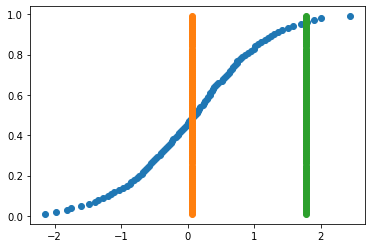

In [10]:
quantiles = sharpes_out_sample.quantile(np.arange(0.01,1.0,0.01)).reset_index().rename({'index':'proba',0:'quantile'},axis=1)
plt.scatter(quantiles['quantile'],quantiles['proba'])
plt.scatter(quantiles['quantile']*0 + sharpes_out_sample.mean(),quantiles['proba'])
plt.scatter(quantiles['quantile']*0 + pnl_in_sample.mean()/pnl_in_sample.std()*16,quantiles['proba'])

# Modele plus avance

In [11]:
nb_signals = 100
nb_dates_in_sample = 1300
nb_dates_out_sample = 260
nb_assets = 80

vol_assets = 0.2/16
correl_assets = 0.8

# vol_signals = 1.0
# correl_signals = 0.0

vol_signals = 0.2/16
correl_signals = 0.8

signal_to_noise = 0.001

rank_betas = 5

cov_assets = vol_assets**2 * pd.DataFrame(correl_assets * np.ones((nb_assets,nb_assets)) + (1-correl_assets)*np.eye(nb_assets))
cov_signals = vol_signals**2 * pd.DataFrame(correl_signals * np.ones((nb_signals,nb_signals)) + (1-correl_signals)*np.eye(nb_signals))

betas = pd.DataFrame(np.random.randn(nb_signals,nb_assets))
betas *= np.sqrt(signal_to_noise * np.trace(cov_assets) / np.trace(betas.T @ cov_signals @ betas))
u,d,v = np.linalg.svd(betas)
betas = pd.concat([pd.DataFrame(d[k] * np.outer(u[:,k],v[k,:]),index=betas.index,columns=betas.columns) for k in range(rank_betas)],keys=range(rank_betas)).groupby(level=1).sum()
betas *= np.sqrt(signal_to_noise * np.trace(cov_assets) / np.trace(betas.T @ cov_signals @ betas))
cov_noise = cov_assets - betas.T @ cov_signals @ betas
d,P = np.linalg.eigh(cov_noise)
cov_noise = pd.DataFrame(P @ np.diag(np.maximum(d,1e-10)) @ P.T)
print('signal to noise = ' + str(np.round(np.trace(betas.T @ cov_signals @ betas) / np.trace(cov_assets),3)))

sqrt_cov_assets = np.linalg.cholesky(cov_assets)
sqrt_cov_signals = np.linalg.cholesky(cov_signals)
sqrt_cov_noise = np.linalg.cholesky(cov_noise)

signal to noise = 0.001


4.0165249296922125
0.4483453035189899


<AxesSubplot:>

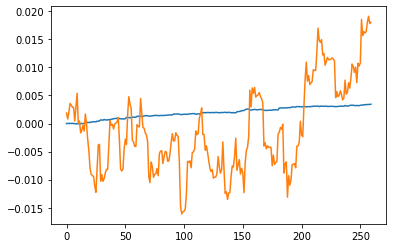

In [12]:
signals = pd.DataFrame(np.random.randn(nb_dates_in_sample,nb_signals) @ sqrt_cov_signals.T)
noise = pd.DataFrame(np.random.randn(nb_dates_in_sample,nb_assets) @ sqrt_cov_noise.T)
assets = signals @ betas+noise

signals_os = pd.DataFrame(np.random.randn(nb_dates_out_sample,nb_signals) @ sqrt_cov_signals.T)
noise_os = pd.DataFrame(np.random.randn(nb_dates_out_sample,nb_assets) @ sqrt_cov_noise.T)
assets_os = signals_os @ betas+noise_os

betas_ols = pd.DataFrame((np.linalg.inv(signals.T @ signals) @ signals.T @ assets).values,index=betas.index,columns=betas.columns)

w_theo = signals_os @ betas
pnl_theo = (w_theo * assets_os).sum(axis=1)

w_ols = signals_os @ betas_ols
pnl_ols = (w_ols * assets_os).sum(axis=1)

print(pnl_theo.mean()/pnl_theo.std()*16)
print(pnl_ols.mean()/pnl_ols.std()*16)

pnl_theo.cumsum().plot()
pnl_ols.cumsum().plot()

In [19]:
assets

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0,-0.026793,-0.027117,-0.019098,-0.009656,-0.007043,-0.014753,-0.001285,-0.010085,-0.011792,-0.013104,...,-0.006130,-0.015370,-0.005239,-0.015296,-0.006420,-0.018886,-0.016958,-0.011389,-0.008210,-0.009132
1,-0.023697,-0.006834,-0.006157,-0.012284,-0.015169,-0.007777,-0.018022,-0.014319,-0.022406,-0.020737,...,-0.011907,-0.012600,-0.015652,-0.020027,0.001854,-0.000913,-0.022066,-0.010843,-0.014779,-0.025122
2,0.000830,-0.008202,0.001381,-0.000270,-0.006713,-0.010903,-0.001273,-0.007483,0.009107,-0.003331,...,0.008029,0.000909,0.009722,-0.002759,-0.007147,0.000050,0.000537,0.004405,0.002413,0.003851
3,-0.009216,0.002014,0.005879,-0.005363,-0.004662,-0.005525,-0.005878,-0.007734,-0.006904,-0.006769,...,0.000821,-0.004692,-0.006866,-0.000624,0.001485,0.001780,-0.007982,-0.006513,-0.007571,-0.005131
4,-0.000577,0.001860,0.003484,0.008952,0.006078,0.007438,-0.001946,0.003957,0.009423,0.006334,...,0.003286,0.003207,0.010367,-0.001631,-0.003366,-0.004647,0.007500,0.010838,-0.004968,-0.000771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,-0.021180,-0.013985,-0.018698,-0.023397,-0.019584,-0.025974,-0.013575,-0.013956,-0.010613,-0.020386,...,-0.015914,-0.031457,-0.008430,-0.010273,-0.018434,-0.001427,-0.010587,-0.016671,-0.019799,-0.018324
1296,-0.018915,-0.011224,-0.024845,-0.025296,-0.012796,-0.005791,-0.004620,-0.022209,-0.011083,-0.022066,...,-0.013671,-0.023083,-0.012316,-0.023733,-0.021470,-0.024270,-0.017756,-0.020122,-0.017232,-0.020547
1297,0.003136,0.010125,0.008186,0.005738,0.001591,0.024678,0.012173,0.016585,0.004725,0.010000,...,0.016255,0.007354,0.016092,0.009469,-0.000951,0.008358,0.007608,0.011412,0.006996,0.012374
1298,-0.009902,-0.012023,-0.008235,-0.003805,0.001471,-0.013464,0.003990,-0.010202,-0.013744,-0.014488,...,-0.005490,-0.010774,-0.009865,-0.010796,-0.012918,0.005486,-0.001000,-0.014622,-0.008999,-0.011224


In [14]:
sharpes = {}
costs_break_even = {}
for i in range(1000):
    signals = pd.DataFrame(np.random.randn(nb_dates_in_sample,nb_signals) @ sqrt_cov_signals.T)
    noise = pd.DataFrame(np.random.randn(nb_dates_in_sample,nb_assets) @ sqrt_cov_noise.T)
    assets = signals @ betas+noise

    signals_os = pd.DataFrame(np.random.randn(nb_dates_out_sample,nb_signals) @ sqrt_cov_signals.T)
    noise_os = pd.DataFrame(np.random.randn(nb_dates_out_sample,nb_assets) @ sqrt_cov_noise.T)
    assets_os = signals_os @ betas+noise_os

    betas_ols = pd.DataFrame((np.linalg.inv(signals.T @ signals) @ signals.T @ assets).values,index=betas.index,columns=betas.columns)

    w_theo = signals_os @ betas
    pnl_theo = (w_theo * assets_os).sum(axis=1)

    w_ols = signals_os @ betas_ols
    pnl_ols = (w_ols * assets_os).sum(axis=1)

    sharpes[('theo',i)] = pnl_theo.mean()/pnl_theo.std()*16
    sharpes[('ols',i)] = pnl_ols.mean()/pnl_ols.std()*16

sharpes = pd.Series(sharpes).reset_index().rename({'level_0':'method','level_1':'simu',0:'sharpe'},axis=1)

In [15]:
pivot = sharpes.pivot_table(index='simu',columns='method')['sharpe']
means = pivot.mean()
quantiles = pivot.quantile(np.arange(0.01,1.0,0.01))

Text(0.5, 1.0, 'beta theo')

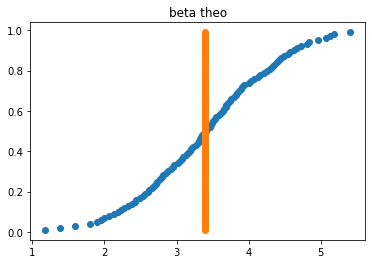

In [16]:
plt.scatter(quantiles['theo'],quantiles.index)
plt.scatter(quantiles['theo']*0+means['theo'],quantiles.index)
plt.title('beta theo')

Text(0.5, 1.0, 'beta ols')

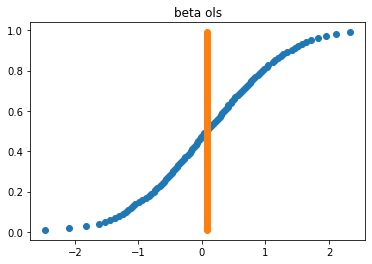

In [17]:
plt.scatter(quantiles['ols'],quantiles.index)
plt.scatter(quantiles['ols']*0+means['ols'],quantiles.index)
plt.title('beta ols')